# Twitter Analysis Example, Featuring the March 15th Debate

In [2]:
import csv
import nltk
from nltk import sentiment
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Step 1, load data from MongoDB

In [3]:
import sys
import pymongo
from pymongo import MongoClient

## insert your mongoDB access key
client = MongoClient('###_MONGO_KEY_HERE_###')

In [4]:
db1 = client.twitter219debate
db2 = client.post_super_tuesday
db3 = client.twitter225debate

In [5]:
#Biden Sanders Debate
bidenSandersDebate = db2.biden_sanders_debate
bsdOb = bidenSandersDebate.find()
tweetsBidenSandersDebate = [(bson['text'],bson['time']) for bson in bsdOb]

In [155]:
#Super Tuesday
superTuesday = db1.super_tuesday
bsdOb = superTuesday.find()
tweetsSuperTuesday = [(bson['text'],bson['time']) for bson in bsdOb]

## Step 2, Score the Tweets

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def score_compound(tweet):
    vs = analyzer.polarity_scores(tweet)
    return (vs['compound'])

In [10]:
scored_BidenSandersDebate = [(bson[0], (score_compound(bson[0])), bson[1]) for bson in tweetsBidenSandersDebate]

In [156]:
scored_SuperTuesday = [(bson[0], (score_compound(bson[0])), bson[1]) for bson in tweetsSuperTuesday]

# March 15 DNC Debate between Biden and Sanders
## Tweet Object Timestamp is in UTC
### Start 8pm EST -> 00:00:00 UTC
### End approx 10:10pm EST -> 02:10:00 UTC
## Tweets with timestamps from duration of debate sliced from DB 
### 77,160 Tweets total in that time.

In [11]:
def checkTime(timeStamp):
    timeStamp = timeStamp.split()
    day = timeStamp[2]
    time = timeStamp[3]
    time = time.replace(':','')
    time = int(time)
    if time <= 21000:
        return True
    else:
        return False

## Step 3, Filter for Tweets In Correct Window of Time

In [12]:
scored_debate_tweets = [tweet for tweet in scored_BidenSandersDebate if checkTime(tweet[2])]
len(scored_debate_tweets)

77160

Important extra step: Order filtered tweets by time stamp

In [13]:
def timeSort(tweet):
    return getTime(tweet[2])
def getTime(timeStamp):
    timeStamp = timeStamp.split()
    time = timeStamp[3]
    time = time.replace(':','')
    time = int(time)
    return time

In [14]:
scored_debate_tweets.sort(key=timeSort)

### Sample Tweets from 2 minutes in that reflect Biden coughing.

In [23]:
scored_debate_tweets[1000:1015]

[('Biden coughs after first word #DemDebate',
  0.0,
  'Mon Mar 16 00:02:38 +0000 2020'),
 ('Joe Biden opens with a cough.\n\nYikes.',
  0.0,
  'Mon Mar 16 00:02:38 +0000 2020'),
 ('Stapler and Waldorf are ready to old man duke it out. Let’s hope for no broken hips.',
  0.0258,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('omg Biden just challenged the coronavirus to a push-up contest',
  -0.1027,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('oh god biden already coughed into his hand in the first minute',
  0.6486,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('Joe Biden starts his first debate answer with a cough. Great.',
  0.6249,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('Overshadowed by the Coronavirus threat, Joe Biden and Bernie Sanders start their Democratic debate tonight on CNN. https://t.co/7qOif3A8uw',
  -0.5267,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('No wonder they are fighting back so much.',
  -0.5719,
  'Mon Mar 16 00:02:39 +0000 2020'),
 ('I legit have been day dreaming about this! #Democ

## Step 4, Filter Tweets by Candidate

In [33]:
#separate tweets by Biden/Sanders
scored_debate_tweets[0]
joe_tweets = [tweet for tweet in scored_debate_tweets if "joe" in tweet[0]]
Joe_tweets = [tweet for tweet in scored_debate_tweets if "Joe" in tweet[0]]
biden_tweets = [tweet for tweet in scored_debate_tweets if "biden" in tweet[0]]
Biden_tweets = [tweet for tweet in scored_debate_tweets if "Biden" in tweet[0]]
bernie_tweets = [tweet for tweet in scored_debate_tweets if "bernie" in tweet[0]]
Bernie_tweets = [tweet for tweet in scored_debate_tweets if "Bernie" in tweet[0]]
sanders_tweets = [tweet for tweet in scored_debate_tweets if "sanders" in tweet[0]]
Sanders_tweets = [tweet for tweet in scored_debate_tweets if "Sanders" in tweet[0]]

In [146]:
JoeBidenTweets = joe_tweets + Joe_tweets + biden_tweets + Biden_tweets
JoeBidenTweets[0]

('“do you think joe biden is just playing tic tac toe with himself” \n- @iraniancowgirl on the candidates writing notes down before the debate',
 0.2023,
 'Mon Mar 16 00:00:02 +0000 2020')

In [40]:
#remove duplicates
joeBidenTweets = []
for tweet in JoeBidenTweets:
    if tweet not in joeBidenTweets:
        joeBidenTweets.append(tweet)

In [38]:
BernieSandersTweets = bernie_tweets + Bernie_tweets + sanders_tweets + Sanders_tweets
len(BernieSandersTweets)

39372

In [42]:
#remove duplicates
bernieSandersTweets = []
for tweet in BernieSandersTweets:
    if tweet not in bernieSandersTweets:
        bernieSandersTweets.append(tweet)

In [43]:
len(joeBidenTweets)

46230

In [44]:
len(bernieSandersTweets)

35223

In [157]:
#Just some examples of scored tweets from other datasets
scored_SuperTuesday[0]

('neither', 0.0, 'Mon Mar 02 19:27:10 +0000 2020')

In [158]:
scored_SuperTuesday[-1]

('Cruel like a #DemocraticPrimary \n#Biden #Bernie #Tulsi',
 -0.3182,
 'Wed Mar 04 18:31:36 +0000 2020')

## Step 5, Perform Analytics
## Getting average sentiment scores for every 30 seconds
### Examples in both Super Tuesday and March 15th Debate dataset

In [159]:
superTuesdayTweets = [(x[2],x[1]) for x in scored_SuperTuesday]

In [161]:
superTuesdayTweets[0]

('Mon Mar 02 19:27:10 +0000 2020', 0.0)

In [51]:
def reduceTimeStamp(timeStamp):
    timeStamp = timeStamp.split()
    return timeStamp[3]

In [147]:
#example of Reduced Timestamp and Score
joeBidenTweets[0:5]

[('00:00:02', 0.2023),
 ('00:00:03', 0.6908),
 ('00:00:36', -0.7717),
 ('00:00:37', 0.0),
 ('00:00:45', 0.1531)]

In [46]:
import pandas as pd

In [171]:
from datetime import datetime

In [ ]:
dtime = 'Mon Mar 02 19:27:10 +0000 2020'

In [172]:
#Time Range for Super Tuesday
time_range_ex = pd.date_range('Mon Mar 02 19:27:10 +0000 2020', 'Wed Mar 04 18:31:36 +0000 2020', freq='1s').strftime('%a %b %d %H:%M:%S +0000 %Y')

In [212]:
time_range = pd.date_range('00:00:00', '02:10:00', freq='1s').strftime('%H:%M:%S')
len(time_range)
time_range_60 = pd.date_range('00:00:00', '02:10:00', freq='60s').strftime('%H:%M:%S')

### Preparing Dictionaries to store analytical data
### Minutes function as keys

In [213]:
scoresWithHighDifference = {}
for time in time_range_60:
    scoresWithHighDifference[time] = []

In [174]:
superTuesdayTweetsBySeconds = {}
for time in time_range_ex:
    superTuesdayTweetsBySeconds[time] = []

In [48]:
bidenTweetsBySeconds = {}
for time in time_range:
    bidenTweetsBySeconds[time] = []

In [49]:
sandersTweetsBySeconds = {}
for time in time_range:
    sandersTweetsBySeconds[time] = []

### Adding Candidate label to data

In [71]:
bidenTweetsBySeconds = []
for pair in joeBidenTweets:
    bidenTweetsBySeconds.append((pair[0], pair[1],'Biden'))

In [72]:
bidenTweetsBySeconds[0:5]

[('00:00:02', 0.2023, 'Biden'),
 ('00:00:03', 0.6908, 'Biden'),
 ('00:00:36', -0.7717, 'Biden'),
 ('00:00:37', 0.0, 'Biden'),
 ('00:00:45', 0.1531, 'Biden')]

In [59]:
for pair in joeBidenTweets:
    bidenTweetsBySeconds[pair[0]]= (pair[1],'Biden')

In [67]:
bidenTweetsBySeconds['00:00:00']

(-0.3622, 'Biden')

In [73]:
sandersTweetsBySeconds = []
for pair in bernieSandersTweets:
    sandersTweetsBySeconds.append((pair[0], pair[1],'Sanders'))

### Functions for Getting Average Sentiment Score Per Minute
#### First function groups all scores into lists by minute
#### Second function calculates average from combined lists

In [100]:
def getScoresPerMinutebyCandidate(scorePerMinute):
    time_range_60 = pd.date_range('00:00:00', '02:10:00', freq='60s').strftime('%H:%M:%S')
    avgBy60Seconds = {}
    for time in time_range_60:
        avgBy60Seconds[time] = []
    for i in range(130):
        for trio in scorePerMinute:
            if trio[0] < time_range_60[i+1] and trio[0] > time_range_60[i]:
                avgBy60Seconds[time_range_60[i]].append((trio[1], trio[2]))
            else:
                continue
    return avgBy60Seconds

In [101]:
bidenTweetScorePerMinute = getScoresPerMinutebyCandidate(bidenTweetsBySeconds)

In [103]:
bidenTweetScorePerMinute['00:10:00']

[(0.5859, 'Biden'),
 (0.0, 'Biden'),
 (-0.2057, 'Biden'),
 (-0.34, 'Biden'),
 (0.0, 'Biden'),
 (-0.5994, 'Biden'),
 (0.4497, 'Biden'),
 (0.0, 'Biden'),
 (-0.3182, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.1999, 'Biden'),
 (0.3612, 'Biden'),
 (0.0, 'Biden'),
 (0.3818, 'Biden'),
 (0.0, 'Biden'),
 (0.3999, 'Biden'),
 (0.0, 'Biden'),
 (0.3559, 'Biden'),
 (-0.34, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.4588, 'Biden'),
 (-0.6444, 'Biden'),
 (0.0, 'Biden'),
 (0.6562, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.4939, 'Biden'),
 (0.2023, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (-0.6705, 'Biden'),
 (0.0, 'Biden'),
 (-0.743, 'Biden'),
 (-0.5574, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (-0.5423, 'Biden'),
 (0.0, 'Biden'),
 (0.0, 'Biden'),
 (0.5106, 'Biden'),
 (-0.5893, 'Biden'),
 (-0.4019, 'Biden'),
 (0.0, 'Biden'),
 (-0.0258, 'Biden'),
 (0.3612, 'Biden'),
 (0.0, 'Biden'),
 (-0.4939, 'Biden'),
 (0.4291, 'Biden'),
 (0.0, 'Biden'),
 (-0.6

In [104]:
sandersTweetScorePerMinute = getScoresPerMinutebyCandidate(sandersTweetsBySeconds)

In [105]:
sandersTweetScorePerMinute['00:10:00']

[(-0.0516, 'Sanders'),
 (-0.5574, 'Sanders'),
 (-0.8316, 'Sanders'),
 (0.0, 'Sanders'),
 (0.6176, 'Sanders'),
 (-0.6901, 'Sanders'),
 (0.6369, 'Sanders'),
 (-0.7436, 'Sanders'),
 (-0.4404, 'Sanders'),
 (0.4215, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (-0.5256, 'Sanders'),
 (0.0, 'Sanders'),
 (0.3182, 'Sanders'),
 (0.0, 'Sanders'),
 (0.3182, 'Sanders'),
 (0.4497, 'Sanders'),
 (0.6701, 'Sanders'),
 (0.0, 'Sanders'),
 (0.5542, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (-0.4168, 'Sanders'),
 (0.4404, 'Sanders'),
 (0.0, 'Sanders'),
 (0.296, 'Sanders'),
 (-0.5983, 'Sanders'),
 (0.0, 'Sanders'),
 (0.2709, 'Sanders'),
 (0.0, 'Sanders'),
 (0.6369, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sanders'),
 (0.1999, 'Sanders'),
 (0.0, 'Sanders'),
 (-0.2023, 'Sanders'),
 (0.4215, 'Sanders'),
 (0.0, 'Sanders'),
 (-0.4019, 'Sanders'),
 (0.5859, 'Sanders'),
 (-0.7727, 'Sanders'),
 (0.6369, 'Sanders'),
 (0.0, 'Sanders'),
 (0.0, 'Sand

In [109]:
def getAvgsPerMinute(scores):
    avgs = {}
    for time in scores:
        total = 0
        num = 0
        scoreList = scores[time]
        num = num + len(scoreList)
        for i in scoreList:
            total = total + i[0]
            candidate = i[1]
        if num == 0:
            avg = 0
        else:
            avg = total/num
        avgs[time] = (avg, num, candidate)
    return avgs

In [115]:
sandersAvgPerMinute = getAvgsPerMinute(sandersTweetScorePerMinute)
sandersAvgPerMinute['00:00:00']

(0.0405110429447853, 163, 'Sanders')

In [117]:
bidenAvgPerMinute = getAvgsPerMinute(bidenTweetScorePerMinute)
bidenAvgPerMinute['00:00:00']

(0.018395876288659792, 194, 'Biden')

### For Loop to demonstrate lack of moments with high differences between candidates

In [219]:
for time in scoresWithHighDifference:
    jRow = bidenAvgPerMinute[time]
    bRow = sandersAvgPerMinute[time]
    jScore = jRow[0]
    bScore = bRow[0]
    if jScore - bScore >= 0.05 or bScore - jScore >= .05:
        scoresWithHighDifference[time] = [jScore, bScore]

In [220]:
scoresWithHighDifference

{'00:00:00': [],
 '00:01:00': [],
 '00:02:00': [0.098826923076923, 0.024045497630331758],
 '00:03:00': [0.11201493243243241, 0.028420202020202023],
 '00:04:00': [],
 '00:05:00': [],
 '00:06:00': [],
 '00:07:00': [0.02307530017152659, 0.07801108033241001],
 '00:08:00': [-0.01128027127003699, 0.07597137404580152],
 '00:09:00': [],
 '00:10:00': [-0.02353920187793427, 0.04072279569892475],
 '00:11:00': [-0.04736601941747568, 0.014433440514469457],
 '00:12:00': [-0.0028953781512604934, 0.059723611111111116],
 '00:13:00': [],
 '00:14:00': [-0.12148370370370358, -0.06204304207119743],
 '00:15:00': [],
 '00:16:00': [],
 '00:17:00': [-0.08041774809160321, -0.00211279069767442],
 '00:18:00': [],
 '00:19:00': [],
 '00:20:00': [],
 '00:21:00': [],
 '00:22:00': [-0.07520536723163844, -0.01893556338028169],
 '00:23:00': [],
 '00:24:00': [],
 '00:25:00': [],
 '00:26:00': [],
 '00:27:00': [],
 '00:28:00': [],
 '00:29:00': [],
 '00:30:00': [],
 '00:31:00': [],
 '00:32:00': [],
 '00:33:00': [],
 '00:34:

## Step 6, Write data into csv files

In [135]:
#March 15 Debate averages by Candidate
fields = ['time','average sentiment score per minute', 'tweets per minute', 'candidate']
filename = "biden_sanders_debate_averages__by_canditate_per_minute.csv"
with open(filename, 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    for key in sandersAvgPerMinute.keys():
        item = sandersAvgPerMinute[key]
        row = [key,item[0],item[1],item[2]]
        csvwriter.writerow(row)
    for key in bidenAvgPerMinute.keys():
        item = bidenAvgPerMinute[key]
        row = [key,item[0],item[1],item[2]]
        csvwriter.writerow(row)

In [222]:
#March 15 data organized by difference in scores between candidates
fields = ['time','AVG Sentiment Per Minute', 'Candidate']
filename = "biden_sanders_with_differences_per_minute.csv"
with open(filename, 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    for key in scoresWithHighDifference.keys():
        item = sandersAvgPerMinute[key]
        row = [key,item[0],'Biden']
        csvwriter.writerow(row)
        row = [key,item[1],'Sanders']
        csvwriter.writerow(row)

In [192]:
# Super Tuesday average score per minute
fields = ['time','average sentiment score per minute', 'tweets per minute']
filename = "Super_Tuesday_per_minute.csv"
with open(filename, 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    for key in superAvgs.keys():
        item = superAvgs[key]
        row = [key,item[0],item[1]]
        csvwriter.writerow(row)

In [380]:
#Data set of number of tweets every 30 seconds
fields = ['time','avg tweets per half minute']
filename = "biden_sanders_debate_numtweets_30.csv"
with open(filename, 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    for key in numTweetsPerHalfMinute.keys():
        f.write("%s,%s\n"%(key,numTweetsPerHalfMinute[key]))

## Step 7, Graph the data

### First, an example of why matplotlib does not cut it

In [47]:
import numpy as np

In [48]:
import matplotlib.pyplot as plt

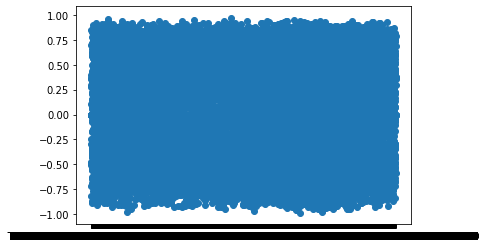

In [57]:
x, y = zip(*xy_225debate)
plt.scatter(x,y)

## Now a demonstration of  GG Plot

In [121]:
from plotnine import ggplot

In [122]:
from plotnine import *

In [124]:
import pandas as pd
import plotnine as p9

### This is what happens if you don't calculate averages correctly

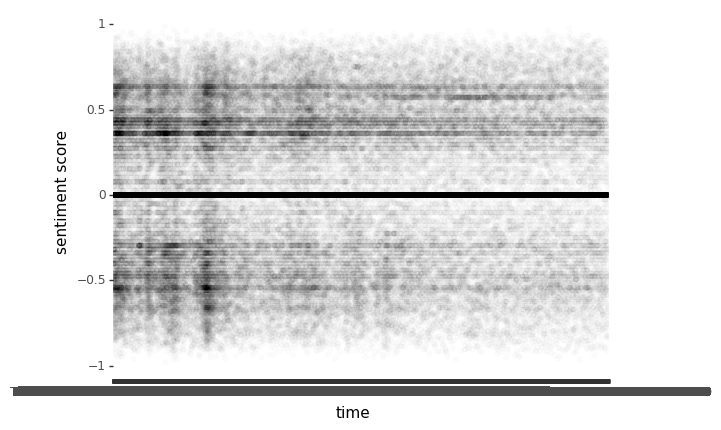

<ggplot: (8775654929057)>

In [87]:
(p9.ggplot(data=feb19Debate,
           mapping=p9.aes(x='time', y='sentiment score'))
 + p9.geom_point(alpha=0.01)
)

### This is what happens if you don't test your functions and check for typos

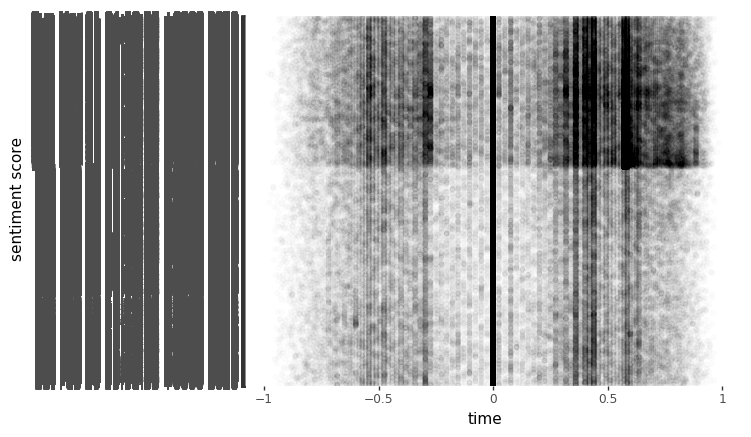

<ggplot: (8775721404613)>

In [98]:
scPrimary = pd.read_csv('sc_primary.csv')
(p9.ggplot(data=scPrimary,
           mapping=p9.aes(x='time', y='sentiment score'))
 + p9.geom_point(alpha=0.01)
)

# Biden Sander's Debate

## Average Sentiment Per 30 Seconds

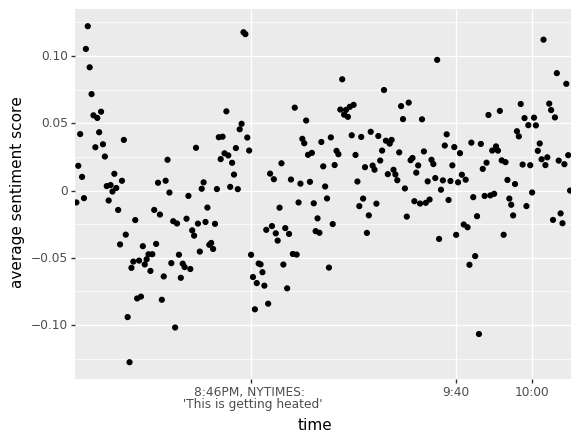

<ggplot: (8779999912453)>

In [367]:
Biden_Sanders_Debate = pd.read_csv('biden_sanders_debate_averages_correct.csv')
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='average sentiment score'))
 + p9.geom_point()
 + p9.scale_x_discrete(breaks=('00:46:00',
                               '01:40:00','02:00:00'),
        labels=("8:46PM, NYTIMES: \n 'This is getting heated'","9:40","10:00"))
)

### Number of Tweets per Minute

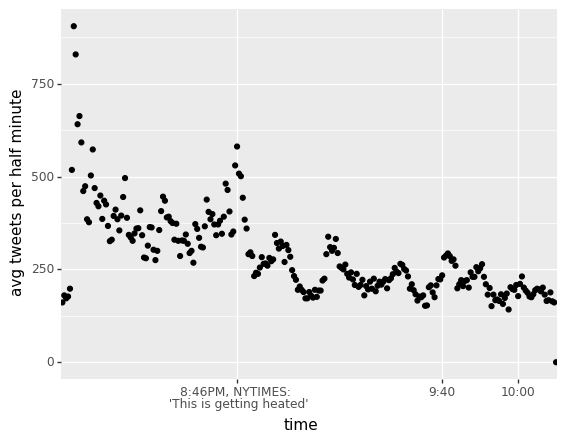

<ggplot: (8779999908157)>

In [381]:
Biden_Sanders_Debate = pd.read_csv('biden_sanders_debate_numtweets_30.csv')
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='avg tweets per half minute'))
 + p9.geom_point()
 + p9.scale_x_discrete(breaks=('00:46:00',
                               '01:40:00','02:00:00'),
        labels=("8:46PM, NYTIMES: \n 'This is getting heated'","9:40","10:00"))
)

# Biden and Sanders Debate Broken Down by Candidate

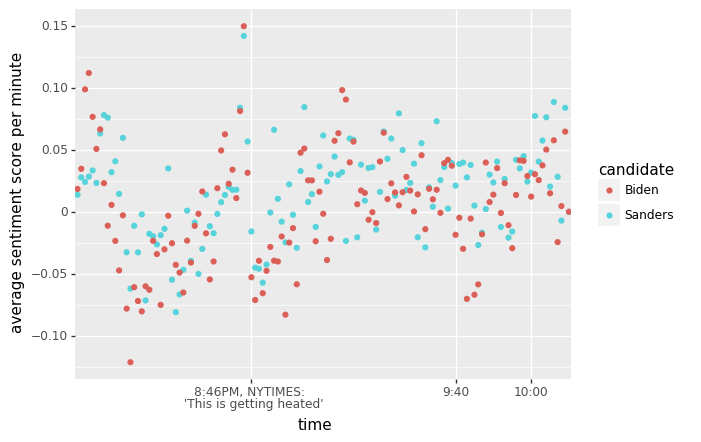

<ggplot: (8784310033633)>

In [138]:
linecolors = ("#714C02", "#01587A", "#024E37")
fillcolors = ("#9D6C06", "#077DAA", "#026D4E")
Biden_Sanders_Debate = pd.read_csv('biden_sanders_debate_averages__by_canditate_per_minute.csv')
# partially transparent points by setting `alpha = 0.5`
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='average sentiment score per minute', colour='candidate'))
           + p9.geom_point()
           + p9.scale_x_discrete(breaks=('00:46:00',
                               '01:40:00','02:00:00'),
        labels=("8:46PM, NYTIMES: \n 'This is getting heated'","9:40","10:00"))
)

### Number of Tweets by Candidate

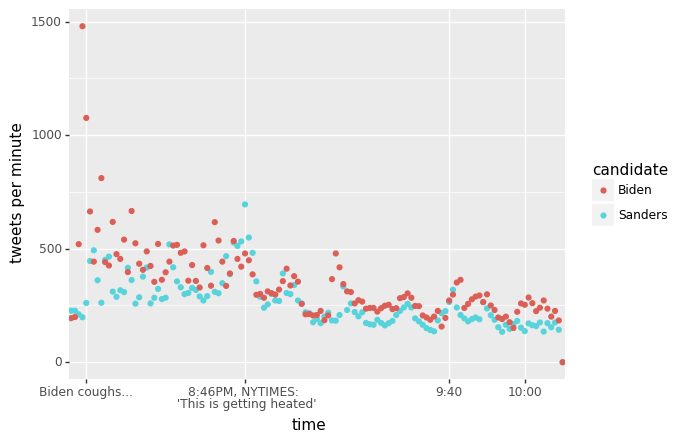

<ggplot: (8784309058157)>

In [140]:
linecolors = ("#714C02", "#01587A", "#024E37")
fillcolors = ("#9D6C06", "#077DAA", "#026D4E")
Biden_Sanders_Debate = pd.read_csv('biden_sanders_debate_averages__by_canditate_per_minute.csv')
# partially transparent points by setting `alpha = 0.5`
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='tweets per minute', colour='candidate'))
           + p9.geom_point()
           + p9.scale_x_discrete(breaks=('00:04:00','00:46:00',
                               '01:40:00','02:00:00'),
        labels=("Biden coughs...","8:46PM, NYTIMES: \n 'This is getting heated'","9:40","10:00"))
)

# Super Tuesday
### This graph demonstrates what happens to a data set when the twitter collection runs into an error while collecting and has to restart

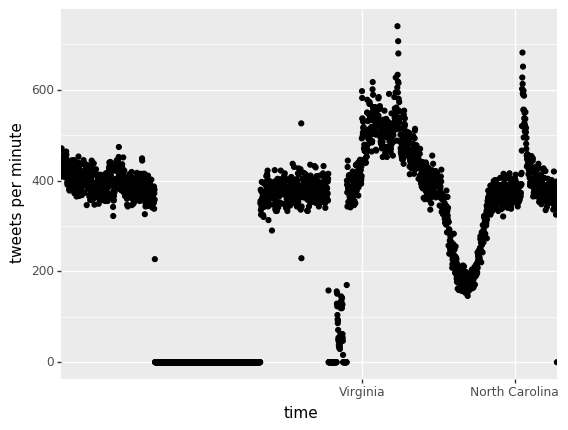

<ggplot: (8784317009461)>

In [257]:
#Tue Mar 03 02:28:10 +0000 2020
Biden_Sanders_Debate = pd.read_csv('Super_Tuesday_per_minute.csv')
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='tweets per minute'))
 + p9.geom_point()
 + p9.scale_x_discrete(breaks=('Tue Mar 03 23:00:10 +0000 202', 'Wed Mar 04 00:00:10 +0000 2020','Wed Mar 04 14:30:10 +0000 2020'),
        labels=("Virginia", "North Carolina", "Bloomberg Drops"))
)

### Biden and Sanders Debate, this time plotted by difference in score

In [241]:

fields = ['time','Biden Score','Sanders Score', 'Difference','Candidate']
filename = "biden_sanders_with_differences_per_minute.csv"
with open(filename, 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    for key in scoresWithHighDifference.keys():
        item = scoresWithHighDifference[key]
        if len(item) > 0:
            row = [key,item[0],item[1],item[2],item[3]]
            csvwriter.writerow(row)
        else:
            row = [key]
            csvwriter.writerow(row)

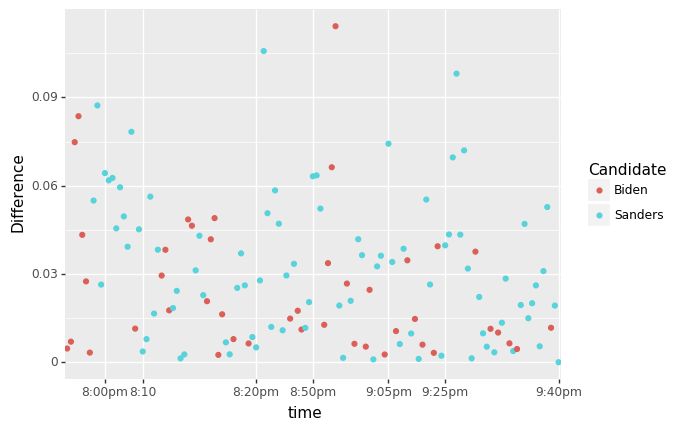

<ggplot: (8784308839541)>

In [243]:

linecolors = ("#714C02", "#01587A", "#024E37")
fillcolors = ("#9D6C06", "#077DAA", "#026D4E")
Biden_Sanders_Debate = pd.read_csv('biden_sanders_with_differences_per_minute.csv')
# partially transparent points by setting `alpha = 0.5`
(p9.ggplot(data=Biden_Sanders_Debate,
           mapping=p9.aes(x='time', y='Difference', colour='Candidate'))
           + p9.geom_point()
           + p9.scale_x_discrete(breaks=('00:0:00','00:10:00','00:20:00','00:50:00','01:05:00','01:25:00',
                               '01:40:00','02:10:00'),
        labels=('8:00pm','8:10', '8:20pm','8:50pm','9:05pm','9:25pm','9:40pm','10:10pm'))
)